In [83]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tifffile import imread
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.exposure import rescale_intensity

In [62]:
fpath = "/scratch/indikar_root/indikar1/shared_data/apollo/region_props/mmRNA4OHTD3.csv"
df = pd.read_csv(fpath)
df.head()

,label,area,bbox_area,convex_area,eccentricity,equivalent_diameter,extent,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,max_intensity,mean_intensity,min_intensity,centroid-0,centroid-1,Channel,Time
0,1,1570.0,2967.0,1664.0,0.927599,44.710022,0.529154,1570.0,74.400841,27.794548,-1.104373,181.923882,0.815686,0.301404,0.000000,22.460510,597.052866,0,0
1,2,6974.0,15295.0,7203.0,0.949009,94.231484,0.455966,6974.0,169.202634,53.341060,-0.908226,387.730014,0.996078,0.309632,0.027451,72.859478,186.912962,0,0
2,3,105.0,187.0,131.0,0.829655,11.562446,0.561497,105.0,16.986354,9.483075,-1.562466,45.798990,0.509804,0.250570,0.000000,9.161905,642.285714,0,0
3,4,7180.0,14280.0,7579.0,0.929413,95.613074,0.502801,7180.0,160.225052,59.129647,-0.915563,381.931024,0.749020,0.319118,0.090196,427.622563,538.025209,0,0
4,5,1418.0,2412.0,1553.0,0.831168,42.490630,0.587894,1418.0,60.296204,33.526001,0.044672,168.988853,0.717647,0.324649,0.000000,330.002821,635.608604,0,0


img.shape=(97, 478, 666)


/tmp/ipykernel_1019282/1901360251.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Proportion of Pixels')

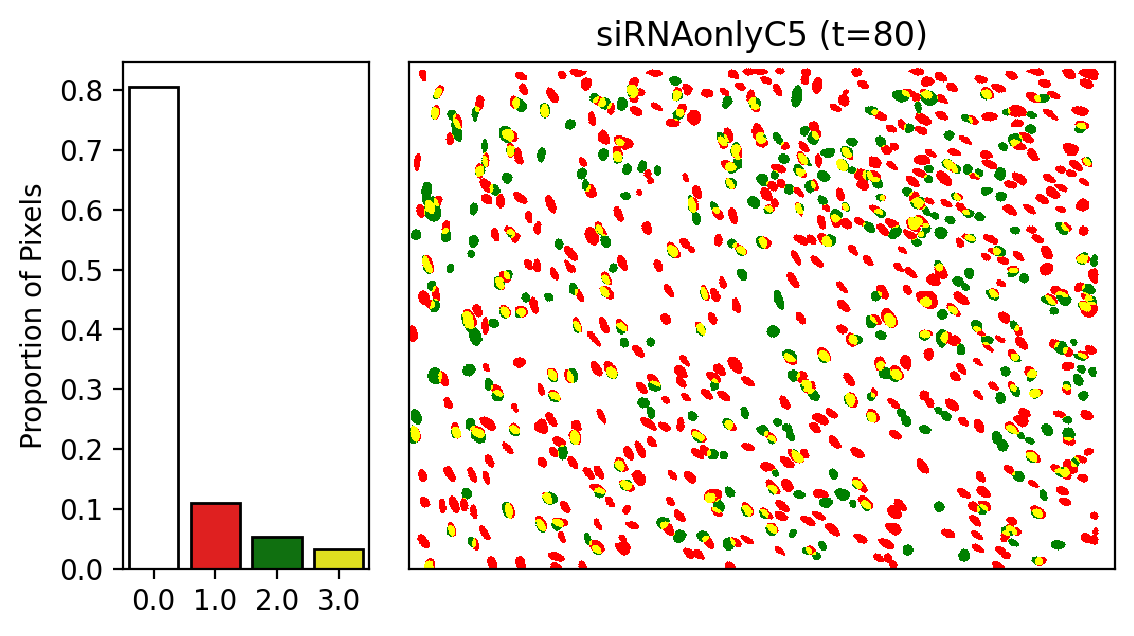

In [107]:

fpath = "/scratch/indikar_root/indikar1/shared_data/apollo/labels/siRNAonlyC5.tiff"
basename = os.path.basename(fpath).split(".")[0]
img = imread(fpath)
print(f"{img.shape=}")

time = 80
img_t = img[time, :, :]
counts = pd.Series(img_t.ravel()).value_counts(normalize=True)

plt.rcParams['figure.dpi'] = 200

sns.heatmap(
    img_t,
    square=True,
    cmap=['w', 'r', 'g', 'yellow'],
    cbar=False,
)

plt.title(f"{basename} (t={time})")
plt.yticks([])
plt.xticks([])
    
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Create a divider for the colorbar
divider = make_axes_locatable(ax)

# Add a colorbar axes to the right of the main plot
ax2 = divider.append_axes("left", size="35%", pad=0.20)
sns.barplot(
    counts,
    ax=ax2,
    ec='k',
    palette=['w', 'r', 'g', 'yellow'],
)

ax2.set_ylabel("Proportion of Pixels")


In [52]:
def count_pixels(img):
    """
    Counts the number of pixels for each unique value in each frame of a 3D numpy array 
    and returns the results in a Pandas DataFrame.

    Args:
        img: A 3D numpy array where the first dimension represents frames, 
             and each 2D frame contains values from a set of unique values.

    Returns:
        A Pandas DataFrame where each row represents a frame, 
        columns are the unique values, and cell values are the corresponding pixel counts.
    """

    all_counts = []
    for frame in img:
        unique_values, counts = np.unique(frame, return_counts=True)
        all_counts.append(dict(zip(unique_values, counts)))

    df = pd.DataFrame(all_counts).fillna(0)  # Create DataFrame and fill missing values with 0
    df = df.reset_index()
    df.columns = ['Time', 'None', 'Red', 'Green', 'Both']
    return df

df = count_pixels(img)
df.head()

ValueError: Length mismatch: Expected axis has 2 elements, new values have 5 elements

([], [])

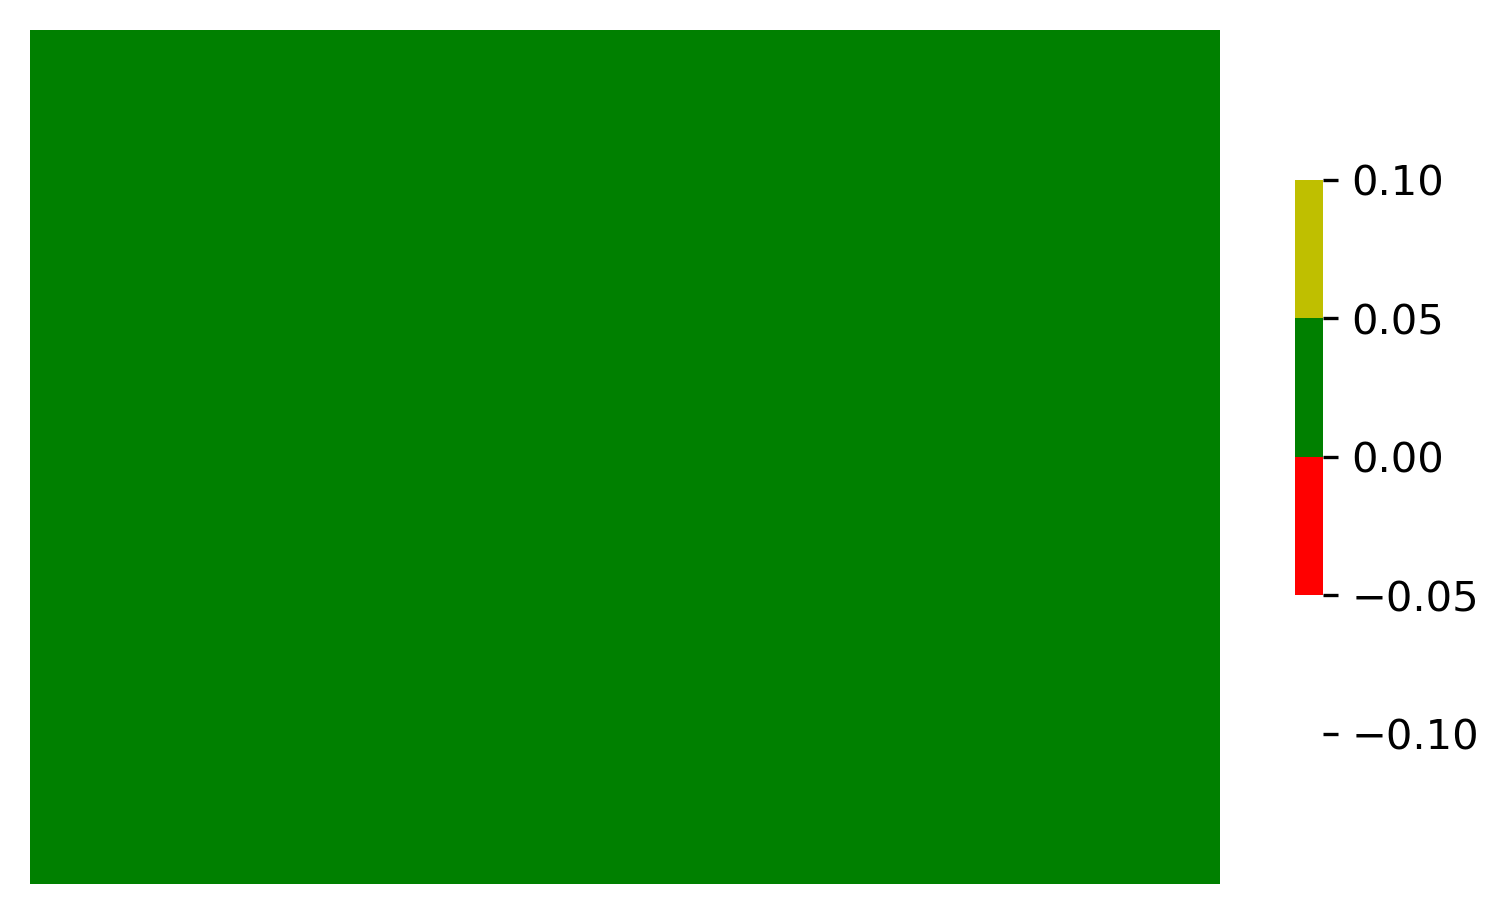

In [53]:
plt.rcParams['figure.dpi'] = 300

sns.heatmap(
    img[2, :, :],
    square=True,
    cmap=['w', 'r', 'g', 'y'],
    cbar_kws={'shrink' : 0.5}
)

plt.yticks([])
plt.xticks([])

In [28]:
def label_frame(red, green):
    """
    Combines two boolean images into a matrix with specific values based on overlap.

    Args:
        red: A boolean numpy array representing the red image.
        green: A boolean numpy array representing the green image.

    Returns:
        A numpy array with the same shape as the input images, containing the combined values.
    """

    # Create an empty output matrix of the same shape
    output = np.zeros_like(red, dtype=np.int32)

    # Assign values based on conditions
    output[(red == True) & (green == False)] = 1  # Red only
    output[(red == False) & (green == True)] = 2  # Green only
    output[(red == True) & (green == True)] = 3   # Both

    return output


def label_cells(img):
    """A function to label cells"""
    label_image = np.zeros(img.shape[1:])
    
    red_channel = 2
    green_channel = 3
    
    for t in range(img.shape[1]):
        red = img[red_channel, t, :, :].astype(bool)
        green = img[green_channel, t, :, :].astype(bool)
        label = label_frame(red, green)
        label_image[t, :, :] = label

    return label_image
        
        
label_image = label_cells(img)
print(f"{label_image.shape=}")

label_image.shape=(97, 478, 666)


([], [])

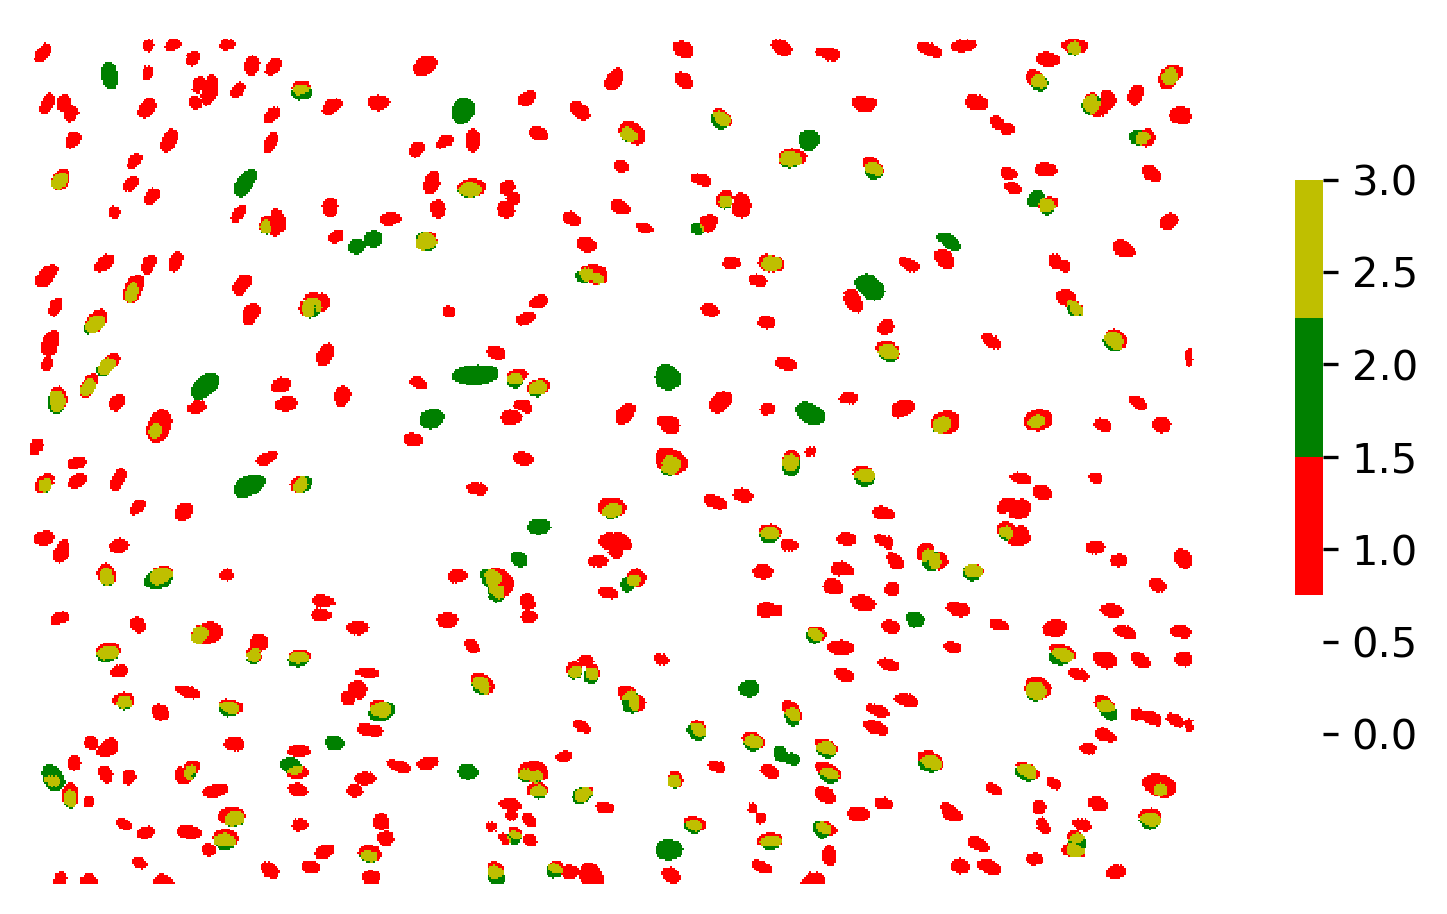

In [39]:
plt.rcParams['figure.dpi'] = 300

sns.heatmap(
    label_image[2, :, :],
    square=True,
    cmap=['w', 'r', 'g', 'y'],
    cbar_kws={'shrink' : 0.5}
)

plt.yticks([])
plt.xticks([])

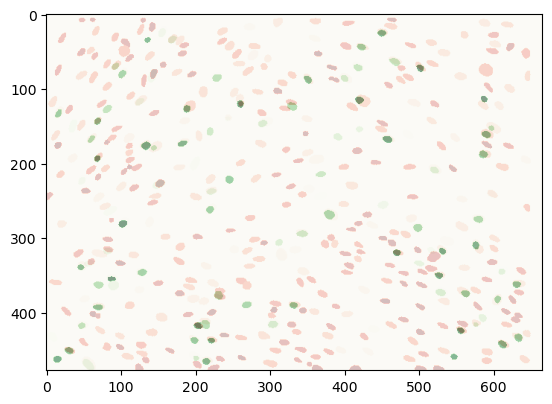

In [19]:
# Plot the first image with reduced transparency
plt.imshow(img[2, 50, :, :], cmap='Reds', alpha=0.5)  # Adjust alpha as needed

# Overlay the second image
plt.imshow(img[3, 50, :, :], cmap='Greens', alpha=0.5)  # Adjust alpha as needed

In [49]:
def get_channel_means(img):
    """
    Computes the mean intensity of all channels over time.

    Args:
        img (numpy.ndarray): The image data with shape (num_channels, time, height, width, 3).

    Returns:
        pd.DataFrame: A DataFrame with columns for each channel and 'time', containing the mean intensities over time.
    """

    num_channels, time_steps, _, _, _ = img.shape
    column_names = [f"Channel {i}" for i in range(num_channels)]

    # Preallocate the result array for efficiency
    result_array = np.zeros((time_steps, num_channels + 1)) 

    for t in range(time_steps):
        img_t = img[:, t, :, :, :]
        img_t = rgb2gray(img_t)
        img_t = rescale_intensity(img_t, out_range=(0, 255))

        means = np.mean(img_t, axis=(1, 2))
        result_array[t, :-1] = means
        result_array[t, -1] = t  # Store the time in the last column

    # Create the DataFrame directly from the result array
    result_df = pd.DataFrame(result_array, columns=column_names + ['Time'])

    return result_df
    
result = get_channel_means(img)
result.head()

,Channel 0,Channel 1,Channel 2,Channel 3,Time
0,84.968606,43.457239,2.273687,11.344068,0.0
1,84.971406,43.772193,2.692217,13.440149,1.0
2,84.970126,44.701852,3.119781,14.898787,2.0
3,84.968568,45.620835,3.509081,16.276554,3.0
4,84.970262,46.694221,3.817625,17.504687,4.0


In [ ]:
def prepareImage(img_t):
    """A function to prepare the image for downstream preprocessing 

    Notes: 
        - time is assumed to be the second dimension
        - works on a single image at a time
        - flattens RGB and rescales
    """
    newImg = []

    # process all channel separately
    for c in range(img_t.shape[0]):
        n_img = img_t[c, :, :].copy()
        n_img = rgb2gray(n_img)
        n_img = rescale(n_img, 
                        (sf, sf),
                        anti_aliasing=False)
        
        n_img = rescale_intensity(n_img, out_range=(0, 255))
        newImg.append(n_img)

    newImg = np.asarray(newImg)
    return [t, newImg]

In [41]:
def get_channel_means(img):
    """
    Computes the mean intensity of all channels over time.

    Args:
        img (numpy.ndarray): The image data with shape (num_channels, time, height, width, 3).

    Returns:
        pd.DataFrame: A DataFrame with columns for each channel and 'time', containing the mean intensities over time.
    """

    num_channels, time_steps, _, _, _ = img.shape
    column_names = [f"Channel {i}" for i in range(num_channels)]

    # Preallocate the result array for efficiency
    result_array = np.zeros((time_steps, num_channels + 1)) 

    for t in range(time_steps):
        img_t = img[:, t, :, :, :]
        means = np.mean(img_t, axis=(1, 2, 3))
        result_array[t, :-1] = means
        result_array[t, -1] = t  # Store the time in the last column

    # Create the DataFrame directly from the result array
    result_df = pd.DataFrame(result_array, columns=column_names + ['Time'])

    return result_df
    
result = get_channel_means(img)
result.head()

,Channel 0,Channel 1,Channel 2,Channel 3,Time
0,84.635396,52.477216,3.556240,7.028874,0.0
1,84.638185,52.857374,4.210296,8.337982,1.0
2,84.636910,53.979159,4.878621,9.249229,2.0
3,84.635358,55.089033,5.487102,10.109410,3.0
4,84.637045,56.384362,5.969392,10.875700,4.0


<Axes: xlabel='t', ylabel='0'>

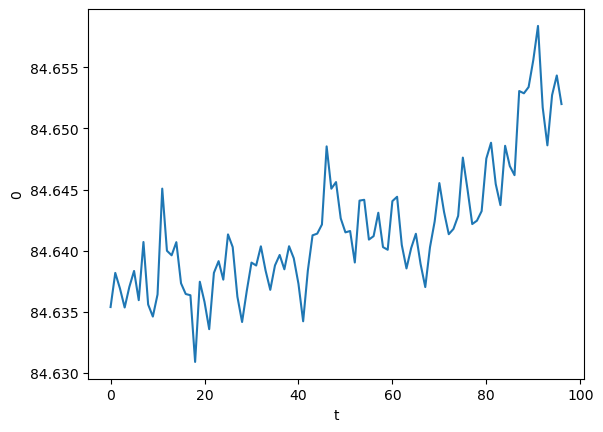

In [34]:
sns.lineplot(
    data=result,
    x='t',

)

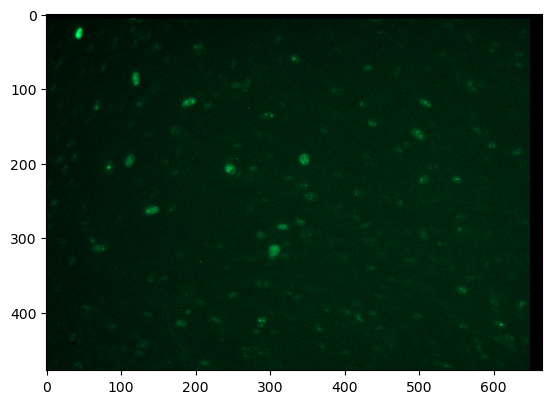

In [8]:
plt.imshow(img[3, 10, :, :, :])